<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023/blob/main/Python/Python_Machine/Machine_Learning_6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ロジスティック回帰ー実践編

In [ ]:
# 最初にインポートしてください
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, log_loss
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import statsmodels.api as sma

今回は、**タイタニック号**という大型乗客船の沈没事故に際して、  
どの人が生存/死亡したのかをデータセットを使って予測します。



Kaggleというデータコンペサイトにも同じデータセットがあります（リンクは[こちら](https://www.kaggle.com/c/titanic)）。  
別のノートブックでは分析結果をKaggleに提出してscoreを出すところまでやろうと思います。

[ヒノマルクさんのこちらの記事](https://www.hinomaruc.com/titanic-dataset-analytics-1/)にも、タイタニックデータセットの説明があります。

## 0.モデル作成の手順

モデル作成を行うまでは、以下のような一連の手順を踏むと良いようです。

1. 問題を定義する<small>（何を知ればよいかを決める）</small>
2. データを入手する<small>（データを入手する）</small>
3. データを確認する<small>（実際にデータを確認・分析して項目同士の関係性や影響の有りそうな項目を見つける）</small>
4. データを整備する<small>（確認した結果、整備すべきものを整備する）</small>
4. 学習用・テスト用データに分割する<small>（モデル作成後に精度を検証するためデータ全体を分割しておきテスト用データを確保する）</small>
5. モデルを構築する<small>（適切な手法を選択しモデルを作成する）</small>
6. モデルを評価する<small>（退避させておいたテスト用データを作成したモデルに読み込ませて結果が正しく出るか精度を確認する）</small>

## 1.問題を定義する

今回から取り組む問題を整理すると、以下のようになります。

> <font color=blue>タイタニック号乗客のデータ項目から、その乗客の生存/死亡(survival=0 or 1)を分類する</font>

データ項目からその乗客のsurvivalが0であるか1であるかを分類するようなモデル</b>を作成していきます。<br>


##2.データを用意する

### 2-1.データを入手する


今回は、seabornのサンプル用データセット"titanic"を利用します。

データセットは、pandas.DataFrameオブジェクトとして取得することができます。

（参考サイト：[こちら](https://biotech-lab.org/articles/1408#i)）

In [ ]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


`info`メソッドで全体のデータの概要を見てみましょう。

In [ ]:
# レコード件数、カラム数、欠損値の存在、データ型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


"titanic"のデータの説明は以下の通りです。

- survival : 生存 or 死亡 (0=死亡、1=生存)
- pclass : チケットクラス (1=上層クラス、2=中級クラス、3=下層クラス)
- sex : 性別 (male=男性、female=女性)
- age : 年齢
- sibsp : タイタニックに同乗している兄弟/配偶者の数
- parch : タイタニックに同乗している親/子供の数
- fare : 料金
- embarked : 出港地 (C=Cherbourg、Q=Queenstown、S=Southampton)

seabornのタイタニックデータフレームでは、以下の情報も付け加えられています。  
(deck以外は基本項目から求めることのできる項目です)

- who : 男性 or 女性
- adult_male : 成人男性であるかどうか
- deck : 乗船していたデッキ
- embark_town : 出港地
- alive : 生存したかどうか
- alone : 一人であったかどうか

## 3.データを確認する

[ヒノマルクさん](https://www.hinomaruc.com/tag/titanic/?order=asc)のブログでは、より詳細にデータの確認を行っています。  
- [データ俯瞰（表形式）](https://www.hinomaruc.com/titanic-dataset-analytics-2-1/)- データの理解中心  
- [データ俯瞰（表形式）](https://www.hinomaruc.com/titanic-dataset-analytics-2-2/)- 目的変数と説明変数の関係性中心
- [データ俯瞰（グラフ形式）](https://www.hinomaruc.com/titanic-dataset-analytics-2-3/)- 目的変数と説明変数の関係性中心

ここでは、各カラムの記述統計量を確認するのにとどめます。

まず、各カラムの欠損割合を確認します。

In [ ]:
# 欠損値の数を計算
chk_null = df.isnull().sum()

# 欠損値の割合を計算
chk_null_pct = chk_null / (df.index.max() + 1)

# 欠損値の数と割合がゼロでない列を抽出し、欠損値テーブルを作成
chk_null_tbl = pd.concat([chk_null[chk_null > 0], chk_null_pct[chk_null_pct > 0]], axis=1)

# 欠損値の割合を基準にテーブルを降順でソートし、列名を変更
chk_null_tbl = chk_null_tbl.sort_values(by=1, ascending=False).rename(columns={0: "欠損レコード数", 1: "欠損割合"})
chk_null_tbl

,欠損レコード数,欠損割合
deck,688,0.772166
age,177,0.198653
embarked,2,0.002245
embark_town,2,0.002245


次に、数値型のカラムの記述統計量を確認します。

- オプションで指定しなければ四分位までしか出力されない。
- 欠損値とはなっていなくても、"0"ばかりのデータなどを確認することができる。
- 99パーセンタイルと最大値を見ることで、異常値が確認しやすくなる。

In [ ]:
# 記述統計量を確認
df.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
10%,0.000000,1.000000,14.000000,0.000000,0.000000,7.550000
20%,0.000000,1.000000,19.000000,0.000000,0.000000,7.854200
30%,0.000000,2.000000,22.000000,0.000000,0.000000,8.050000
40%,0.000000,2.000000,25.000000,0.000000,0.000000,10.500000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
60%,0.000000,3.000000,31.800000,0.000000,0.000000,21.679200


次に、名義型のカラムの記述統計量を確認します。

- レコード数、ユニーク数、最頻値、最頻値の出現数を確認できる。

In [ ]:
# 名義型の変数の統計量を確認
df.describe(include=['O'])

,sex,embarked,who,embark_town,alive
count,891,889,891,889,891
unique,2,3,3,3,2
top,male,S,man,Southampton,no
freq,577,644,537,644,549


## 4.データを整備する

### 4-1.データのクレンジング




どうやら今回のデータセットは、欠損値が4つのカラムで見られるようです。

![](https://imgur.com/dKcyWNT.png)

欠損値は多くの場合、以下のパターンで欠損値を何とかすることが多いようです。
* 1.欠損値が含まれるデータを削除する
* 2.欠損値が含まれる項目を丸ごと削除する
* 3.欠損値を別の値に置換する

#### 欠損値が含まれる項目を丸ごと削除する

"deck"カラムはあまりにも欠損値が多すぎるので、項目として丸ごと削除してしまうこととします。



In [ ]:
df = df.drop('deck', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  embark_town  889 non-null    object  
 12  alive        891 non-null    object  
 13  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(5)
memory usage: 79.4+ KB


#### 欠損値を別の値に置換する

##### embarkedカラム

まずは"embarked"（出港地）カラムが欠損している行を表示してみましょう。

In [ ]:
print(df[df["embarked"].isnull() == True])

     survived  pclass     sex   age  sibsp  parch  fare embarked  class  \
61          1       1  female  38.0      0      0  80.0      NaN  First   
829         1       1  female  62.0      0      0  80.0      NaN  First   

       who  adult_male embark_town alive  alone  
61   woman       False         NaN   yes   True  
829  woman       False         NaN   yes   True  


どうやら、年齢以外の特徴量がすべて同じのようです。

"pclass"（客室等級）の値は1でした。

"pclass"ごとの"embarked"カラムの値を見てみましょう。

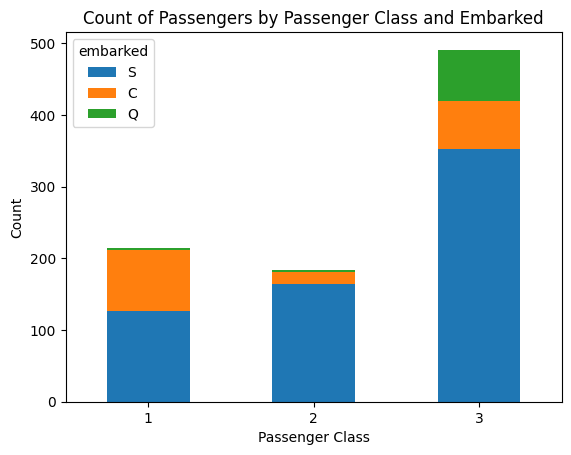

In [ ]:
# "pclass"と"embarked"ごとにユニークな値の数を計算
count_data = df.groupby(['pclass', "embarked"])["embarked"].count().unstack()

# "person"カラムの順序を指定
desired_order = ["S", "C", "Q"]
count_data = count_data[desired_order]

# グラフを描画
count_data.plot(kind='bar', stacked=True)

# グラフの設定
plt.title('Count of Passengers by Passenger Class and Embarked')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 凡例を表示
plt.legend(title='embarked', loc='best')

# グラフを表示
plt.show()

"pclass"の値が1のデータは、"embarked"カラムの値が"S"のものが  
割合として最も多いようです。

ほぼ同じ意味の"embark_town"カラムと合わせて、欠損を埋めてしまいましょう。

In [ ]:
# inplace=Trueとすると、代入しなくても上書きしてくれる
df['embarked'].fillna('S', inplace=True)
df['embark_town'].fillna('Southampton', inplace=True)

[ヒノマルクさんの記事](https://www.hinomaruc.com/titanic-dataset-analytics-3-2/#toc5)や[3PySciさんの記事](https://3pysci.com/kaggle-titanic-10/)でも、embarkedカラムの欠損値処理を行っています。

##### ageカラム

"age"カラムは177件もの欠損値があります。

いろいろ方法はありますが、ここでは"pclass"カラムごとに  
"age"カラムの値の平均値を取って、それを使って欠損を埋めていきます。

In [ ]:
# "Pclass"ごとの"age"の平均値を計算し、それを新しい列として追加
age_mean_by_pclass = df.groupby('pclass')['age'].mean()
print(age_mean_by_pclass)
print("----------------")
df['age_mean_by_pclass'] = df['pclass'].map(age_mean_by_pclass)

# "age"が欠損している場合、対応する"Pclass"の平均値で欠損を埋める
df['age'].fillna(df['age_mean_by_pclass'], inplace=True)

# 不要な"age_mean_by_pclass"列を削除
df.drop(columns=['age_mean_by_pclass'], inplace=True)

df.info()

pclass
1    38.233441
2    29.877630
3    25.140620
Name: age, dtype: float64
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     891 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  embark_town  891 non-null    object  
 12  alive        891 non-null    object  
 13  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(5)
memory usage: 79.4+ KB


どうやら欠損値はなくなったようです。

[ヒノマルクさんの記事](https://www.hinomaruc.com/titanic-dataset-analytics-3-2/#toc6)や[3PySciさんの記事](https://3pysci.com/kaggle-titanic-15/)でも、ageカラムの欠損値処理を行っています。

### 4-2.データの整理



#### 1.不要なデータ項目の削除


今回はほとんど意味が同じであるカラム群がいくつか存在するので、削除していきます。

- "sex"と"who"
- "survived"と"alive"
- "embarked"と"embark_town"
- "pclass"と"class"

In [ ]:
# 複数の列を一度に削除
df = df.drop(['who', 'alive', 'embark_town', 'class'], axis=1)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,adult_male,alone
0,0,3,male,22.0,1,0,7.2500,S,True,False
1,1,1,female,38.0,1,0,71.2833,C,False,False
2,1,3,female,26.0,0,0,7.9250,S,False,True
3,1,1,female,35.0,1,0,53.1000,S,False,False
4,0,3,male,35.0,0,0,8.0500,S,True,True


次に、カラム"adult_male" と "alone" は他のデータ項目から作成できるものになりますので、  
これらも削除してしまいます。

In [ ]:
# 複数の列を一度に削除
df = df.drop(["adult_male", "alone" ], axis=1)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


データがかなりすっきりしてきました。

#### 2.データ型の変更

"pclass"カラムの値はint型となっていますが、
 数値型というよりは名義型のデータであるので文字型に変換します。

In [ ]:
df['pclass'] = df['pclass'].apply(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    object 
 2   sex       891 non-null    object 
 3   age       891 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  891 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


#### 3.ダミー変数の作成処理

one-hotエンコーディングを行います。

In [ ]:
# one-hotエンコーディング
df = pd.get_dummies(df, columns=['pclass', 'sex', 'embarked'], drop_first=True)
df.head()

,survived,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
0,0,22.0,1,0,7.2500,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,1,0,1


これでようやく、全てのデータ項目が数値になりました。

### 4-3.そのほかのデータの加工

[ヒノマルクさんの記事](https://www.hinomaruc.com/titanic-dataset-analytics-3-1/)にもありますが、  
ほかにも以下のような加工をすることで、モデルの精度向上が期待できます。



- 外れ値処理

  - 外れ値かどうかを判断して除外するかどうかを検討する。

- 特徴量エンジニアリング

  - 新しい意味を持つ変数を作成する。
  - より説明力がある変数が作成できたり、変数の数を減らせる可能性がある。
  
- 変数選択

  - モデリングに必要なさそうな変数は除外する。
  - 計算量を減らせたり多重共線性を防げる可能性がある。

## 5.学習用・テスト用データに分割する

hold-out法で、整備したデータを  
「学習用データ」と「テスト用データ」に分割します。

In [ ]:
# 目的変数に"survived"、説明変数にそれ以外の6つのカラムを指定
X = df.drop('survived', axis=1)
y = df['survived']

# 学習データとテストデータ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 6.モデルを作成する

前処理とモデルを一つのオブジェクトとして扱うことができるpipelineを使って、  
いよいよ、ロジスティック回帰を行っていきます。

In [ ]:
# Pipelineを定義
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # データの標準化
    ('model', LogisticRegression(penalty='none'))  # ロジスティック回帰モデル
])
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(penalty='none'))])

それぞれのラベルの分類結果を取得したいときは、  
**`.predict(X)`**を使います。

In [ ]:
y_pred = pipeline.predict(X_test)
y_pred[:5]

array([0, 0, 0, 1, 1])

それぞれのラベルの確率$p(X)$を取得したいときは、  
**`.predict_proba(X)`**を使います。

In [ ]:
y_pred_proba = pipeline.named_steps['model'].predict_proba(X_test)
print(pipeline.named_steps['model'].classes_)  # クラスの値
print(pipeline.named_steps['model'].intercept_)  # 切片の値
print(y_pred_proba[:5])  # それぞれの出現確率

[0 1]
[-0.63385095]
[[9.99999962e-01 3.79687366e-08]
 [9.99999981e-01 1.93664489e-08]
 [9.99287386e-01 7.12614442e-04]
 [9.99999008e-01 9.91882944e-07]
 [9.99999988e-01 1.24180479e-08]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


係数の値を確認してみましょう。

In [ ]:
# ロジスティック回帰モデルの係数を取得
coef = pipeline.named_steps['model'].coef_[0]

# 係数をカラムと対応づけて表示
print(pd.Series(coef, index=X.columns))

age          -0.596742
sibsp        -0.475050
parch        -0.089960
fare          0.068937
pclass_2     -0.399697
pclass_3     -1.135820
sex_male     -1.311075
embarked_Q   -0.005554
embarked_S   -0.196981
dtype: float64


#### 交差エントロピーの導出

学習(fit)時には、学習データにおける交差エントロピーを最小にするように、  
パラメータ$\theta$を求めています。

その後、テストデータを使って交差エントロピーを求めたい場合、  
`log_loss(y_test, y_pred_proba)`を使って求めることができます。

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred_proba)

0.4411047538505964

##  7.モデルを評価する

モデルの評価方法については、ここでは取り上げません。